In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import os
import pickle
import json

from tqdm import tqdm
from scipy.io import wavfile
from copy import deepcopy

from utilities import plot_cm

### Prepare Loaders

In [2]:
#path_dataset = '../input/'
path_dataset = '/home/edoardobucheli/Datasets/FSDKaggle2018'

path_train = os.path.join(path_dataset,'audio_train_16k')
path_test = os.path.join(path_dataset,'audio_test_16k')

### Load Label Data

In [3]:
train_data = pd.read_csv(os.path.join(path_dataset,'train_post_competition.csv'))
test_data = pd.read_csv(os.path.join(path_dataset,'test_post_competition_scoring_clips.csv'))

In [4]:
from utilities import get_all_classes_dict, get_classes_to_meta_dict, get_labels

In [5]:
num_to_label, label_to_num, n_classes = get_all_classes_dict(train_data)
label_to_meta, label_num_to_meta = get_classes_to_meta_dict(label_to_num)

In [6]:
data_cur = train_data[train_data['manually_verified']==1]
data_noi = train_data[train_data['manually_verified']==0]

In [7]:
meta_labels_all, labels_all = get_labels(train_data,label_to_meta, label_to_num)
meta_labels_cur, labels_cur = get_labels(data_cur,label_to_meta, label_to_num)
meta_labels_noi, labels_noi = get_labels(data_noi,label_to_meta, label_to_num)
meta_labels_test, labels_test = get_labels(test_data,label_to_meta, label_to_num)

In [8]:
n_meta_classes = len(np.unique(meta_labels_all))

### Load Data

In [9]:
pickle_test = './preprocessed_test/PS-257-HL256-WF16k-64k'

In [10]:
with open(pickle_test, 'rb') as fp:
    x_test = pickle.load(fp)

In [11]:
x_test_private = [f for i,f in enumerate(x_test) if test_data['usage'][i] == 'Private']
labels_test_private = [f for i,f in enumerate(labels_test) if test_data['usage'][i] == 'Private']
meta_labels_test_private = [f for i,f in enumerate(meta_labels_test) if test_data['usage'][i] == 'Private']

In [12]:
new_x_test = []

for this_x in x_test_private:
    if this_x.shape[1] == 251:
        this_x = this_x[:,:250]
    new_x_test.append(this_x)
    
x_test_private = new_x_test

In [13]:
pickle_test_32 = './preprocessed_test/PS-257-HL256-WF32k-64k'

with open(pickle_test_32, 'rb') as fp:
    x_test_32k = pickle.load(fp)

In [14]:
x_test_32k_private = [f for i,f in enumerate(x_test_32k) if test_data['usage'][i]=='Private']

In [15]:
temp_x_test = []

for this_x in x_test_32k_private:
    if this_x.shape[1] == 251:
        this_x = this_x[:,:250]
    temp_x_test.append(this_x)
    
x_test_32k_private = temp_x_test

In [16]:
sr = 16000
file_length = 64000
hop_length = 256
freq_res = 257
frames = int(np.ceil(file_length/hop_length))

### Load Network

In [17]:
from networks.CNNetworks2D import malley_cnn_120
from tensorflow.keras.optimizers import Adam

In [18]:
input_shape = ([freq_res,frames])
lr = 0.001
mc_model = malley_cnn_120(input_shape,n_meta_classes)
mc_model.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])
#mc_model.save_weights('./weights_mc_malley.h5')
mc_model.load_weights('./outputs_mc/best_weights/malley-MC-16k-PS-257-256[0].h5')
mc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 257, 250)          0         
_________________________________________________________________
expand_dims (Lambda)         (None, 257, 250, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 257, 250, 64)      1408      
_________________________________________________________________
activation (Activation)      (None, 257, 250, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 250, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 250, 128)      57472     
_________________________________________________________________
activation_1 (Activation)    (None, 85, 250, 128)      0         
__________

### Make Inference

In [19]:
from utilities import create_quick_test_2d

In [20]:
from utilities import evaluate_complete_files

In [21]:
y_scores_MC,edo = evaluate_complete_files(x_test_private,meta_labels_test_private,mc_model,[257,250])

100%|██████████| 301/301 [00:03<00:00, 95.15it/s] 


In [22]:
y_hat_MC = np.argmax(y_scores_MC,axis = 1)

In [23]:
np.mean(y_hat_MC==meta_labels_test_public)

0.9601328903654485

In [24]:
x_test_2 = create_quick_test_2d(x_test_private,freq_res,frames)
mc_model.evaluate(x_test_2,meta_labels_test_private)

301/301 [==============================] - 2s 7ms/step


[0.19764579145664787, 0.9568106312292359]

In [25]:
#x_test_2 = create_quick_test_2d(x_test,freq_res,frames)
#mc_model.evaluate(x_test_2,meta_labels_test)
#y_scores_MC = mc_model.predict(x_test_2)
#y_hat_MC = np.argmax(y_scores_MC, axis = 1)

### Plot Confusion Matrix

In [26]:
from utilities import plot_cm

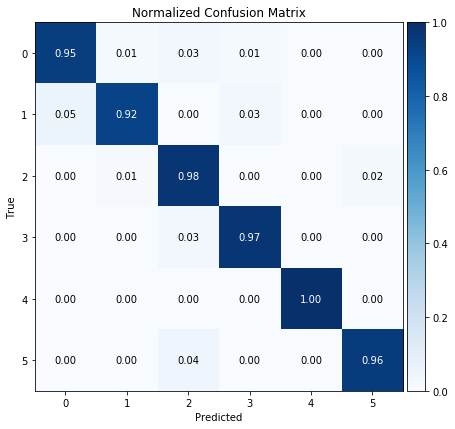

In [27]:
plot_cm(meta_labels_test_private,y_hat_MC,figsize = (7,7))
plt.savefig('./cm_MC-Private.eps')

In [28]:
del(mc_model)

### Separate Given Inference

In [29]:
c0_indx = [i for i,f in enumerate(y_scores_MC) if f[0] >= 0.2]
c1_indx = [i for i,f in enumerate(y_scores_MC) if f[1] >= 0.2]
c2_indx = [i for i,f in enumerate(y_scores_MC) if f[2] >= 0.2]
c3_indx = [i for i,f in enumerate(y_scores_MC) if f[3] >= 0.2]
c4_indx = [i for i,f in enumerate(y_scores_MC) if f[4] >= 0.2]
c5_indx = [i for i,f in enumerate(y_scores_MC) if f[5] >= 0.2]

### Create General Class Vector

In [30]:
all_scores =np.zeros((len(x_test_public),47))

### Cluster 0 

In [31]:
x0 = [x_test_private[f] for f in c0_indx]
y0 = [labels_test_private[f] for f in c0_indx]

In [32]:
with open('./Clustering_V1_mappings/c0_mapping', 'rb') as fp:
    c0_label_mapping = pickle.load(fp)
    
c0_label_mapping_inv = dict([[v,k] for [k,v] in c0_label_mapping.items()])
c0_label_mapping_inv[len(c0_label_mapping_inv)] = 41

c0_labels = list(c0_label_mapping.keys())

In [33]:
y0_2 = []

for f in y0:
    if f in c0_labels:
        y0_2.append(c0_label_mapping[f])
    else:
        y0_2.append(len(c0_labels))

In [34]:
sr = 16000
file_length = 64000
hop_length = 256
freq_res = 257
frames = int(np.ceil(file_length/hop_length))

In [35]:
input_shape = [freq_res,frames]

In [36]:
modelc0 = malley_cnn_120(input_shape,len(c0_label_mapping)+1)
modelc0.load_weights('./outputs/best_weights/malley-C0-16k-PS-257-HL256[0].h5')
modelc0.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [37]:
y_scores_c0,edo= evaluate_complete_files(x0,y0_2,modelc0,[freq_res,frames])
y_hat_c0 = np.argmax(y_scores_c0,axis = 1)
np.mean(y_hat_c0==y0_2)

100%|██████████| 74/74 [00:00<00:00, 124.87it/s]


0.8648648648648649

In [38]:
x0_2 = create_quick_test_2d(x0,freq_res,frames)
modelc0.evaluate(x0_2,y0_2)

74/74 [==============================] - 1s 7ms/step


[0.8126366267333159, 0.8648648632539285]

### Save Scores in General Scores

In [39]:
y_scores_c0_1 = modelc0.predict(x0_2)
y_hat_c0_1 = np.argmax(y_scores_c0,axis = 1)

In [40]:
y_hat_c0_orig = [c0_label_mapping_inv[f] for f in y_hat_c0]

In [41]:
for i,this_scores in zip(c0_indx,y_scores_c0):
    for j,f in enumerate(this_scores):
        all_scores[i,c0_label_mapping_inv[j]] = f * (1-this_scores[-1])#*y_scores_MC[i][0]

In [42]:
labels = [num_to_label[f] for f in c0_labels]
labels.append('Unknown')

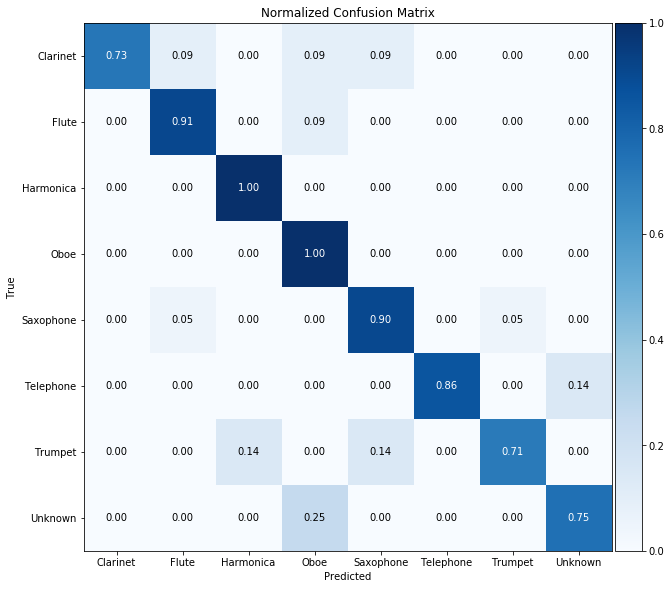

In [43]:
plot_cm(y0_2,y_hat_c0,figsize = (10,10), labels = labels)
plt.savefig('./cm_MC0-Private.eps')

In [44]:
del(modelc0)

### Cluster 1

In [45]:
x1 = [x_test_32k_private[f] for f in c1_indx]
y1 = [labels_test_private[f] for f in c1_indx]

In [46]:
with open('./Clustering_V1_mappings/c1_mapping', 'rb') as fp:
    c1_label_mapping = pickle.load(fp)

c1_label_mapping_inv = dict([[v,k] for [k,v] in c1_label_mapping.items()])
c1_label_mapping_inv[len(c1_label_mapping_inv)] = 42
    
c1_labels = list(c1_label_mapping.keys())

In [47]:
y1_2 = []

for f in y1:
    if f in c1_labels:
        y1_2.append(c1_label_mapping[f])
    else:
        y1_2.append(len(c1_labels))

In [48]:
sr = 32000
file_length = 64000
hop_length = 256
freq_res = 257
frames = int(np.ceil(file_length/hop_length))

input_shape = [freq_res,frames]

In [49]:
modelc1 = malley_cnn_120(input_shape,len(c1_labels)+1)
modelc1.load_weights('./outputs/best_weights/malley-C1-32k-PS-257-HL256[0].h5')
modelc1.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [50]:
y_scores_c1,edo= evaluate_complete_files(x1,y1_2,modelc1,[freq_res,frames])
y_hat_c1 = np.argmax(y_scores_c1,axis = 1)
np.mean(y_hat_c1==y1_2)

100%|██████████| 38/38 [00:00<00:00, 68.00it/s]


0.9473684210526315

In [51]:
x1_2 = create_quick_test_2d(x1,freq_res,frames)
modelc1.evaluate(x1_2,y1_2)

38/38 [==============================] - 0s 5ms/step


[0.6375338842994288, 0.9210526284418608]

### Save Scores in General Scores

In [52]:
#y_scores_c1 = modelc1.predict(x1_2)
#y_hat_c1 = np.argmax(y_scores_c1,axis = 1)

In [53]:
y_hat_c1_orig = [c1_label_mapping_inv[f] for f in y_hat_c1]

In [54]:
for i,this_scores in zip(c1_indx,y_scores_c1):
    for j,f in enumerate(this_scores):
        all_scores[i,c1_label_mapping_inv[j]] = f*(1-this_scores[-1])#*y_scores_MC[i][1]

In [55]:
labels = [num_to_label[f] for f in c1_labels]
labels.append('Unknown')

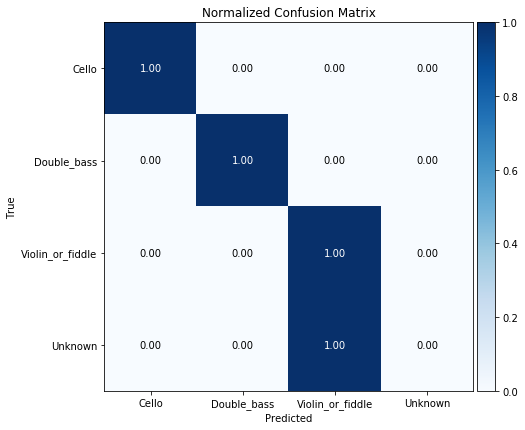

In [56]:
plot_cm(y1_2,y_hat_c1,figsize = (7,7), labels = labels)
plt.savefig('./cm_MC1-private.eps')

del(modelc1)

### Cluster 2

In [57]:
x2 = [x_test_32k_private[f] for f in c2_indx]
y2 = [labels_test_private[f] for f in c2_indx]

In [58]:
with open('./Clustering_V1_mappings/c2_mapping', 'rb') as fp:
    c2_label_mapping = pickle.load(fp)
    
c2_label_mapping_inv = dict([[v,k] for [k,v] in c2_label_mapping.items()])
c2_label_mapping_inv[len(c2_label_mapping_inv)] = 43
    
c2_labels = list(c2_label_mapping.keys())

In [59]:
y2_2 = []

for f in y2:
    if f in c2_labels:
        y2_2.append(c2_label_mapping[f])
    else:
        y2_2.append(len(c2_labels))

In [60]:
sr = 32000
file_length = 64000
hop_length = 256
freq_res = 257
frames = int(np.ceil(file_length/hop_length))

input_shape = [freq_res,frames]

In [61]:
modelc2 = malley_cnn_120(input_shape,len(c2_labels)+1)
modelc2.load_weights('./outputs/best_weights/malley-C2-32k-PS-257-HL256[0].h5')
modelc2.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [62]:
y_scores_c2,edo= evaluate_complete_files(x2,y2_2,modelc2,[freq_res,frames])
y_hat_c2 = np.argmax(y_scores_c2,axis = 1)
np.mean(y_hat_c2==y2_2)

100%|██████████| 126/126 [00:01<00:00, 63.87it/s]


0.8253968253968254

In [63]:
x2_2 = create_quick_test_2d(x2,freq_res,frames)
modelc2.evaluate(x2_2,y2_2)

126/126 [==============================] - 1s 8ms/step


[1.071950253986177, 0.8015873053717235]

### Save Scores in General Scores

In [64]:
#y_scores_c2 = modelc2.predict(x2_2)
#y_hat_c2 = np.argmax(y_scores_c2,axis = 1)

In [65]:
y_hat_c2_orig = [c2_label_mapping_inv[f] for f in y_hat_c2]

In [66]:
for i,this_scores in zip(c2_indx,y_scores_c2):
    for j,f in enumerate(this_scores):
        all_scores[i,c2_label_mapping_inv[j]] = f*(1-this_scores[-1])#*y_scores_MC[i][2]

In [67]:
labels = [num_to_label[f] for f in c2_labels]
labels.append('Unknown')

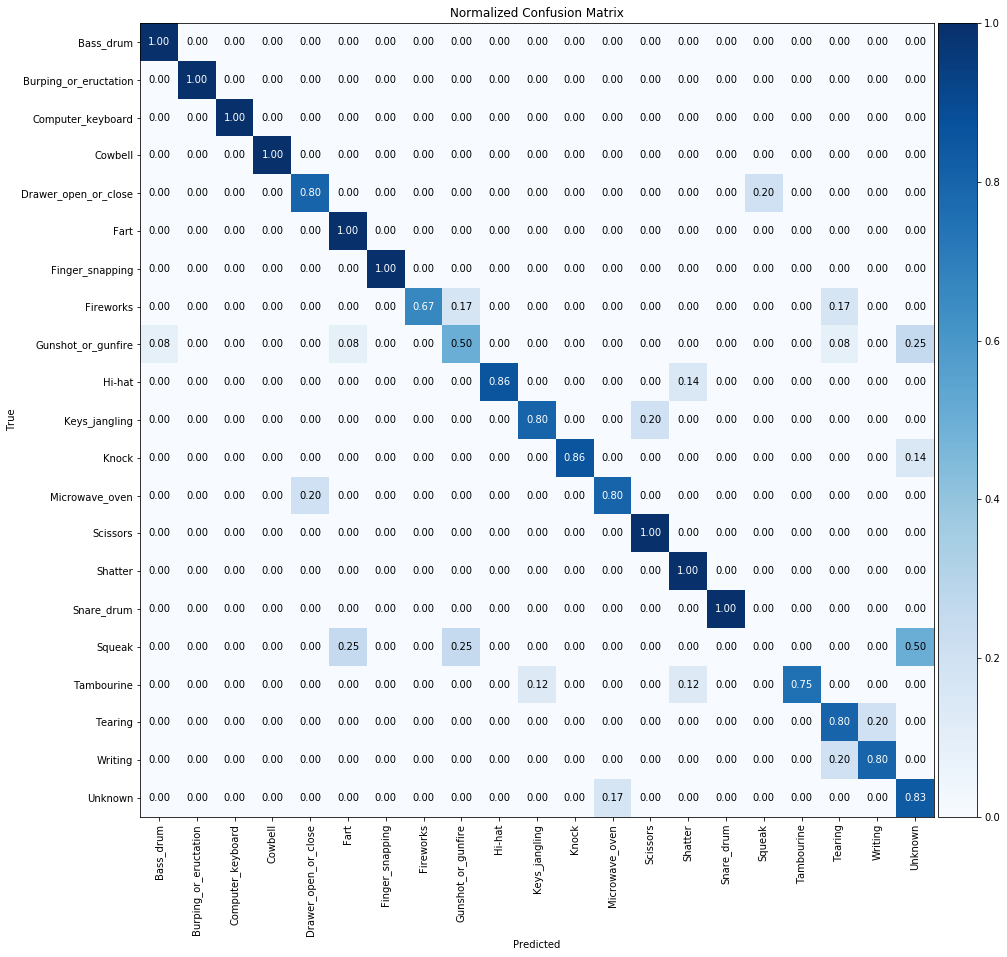

In [68]:
plot_cm(y2_2,y_hat_c2,figsize = (15,15), labels = labels, xrotation = 90)
plt.savefig('./cm_MC2-private.eps')

del(modelc2)

### Cluster 3

In [69]:
x3 = [x_test_32k_private[f] for f in c3_indx]
y3 = [labels_test_private[f] for f in c3_indx]

In [70]:
with open('./Clustering_V1_mappings/c3_mapping', 'rb') as fp:
    c3_label_mapping = pickle.load(fp)
    
c3_label_mapping_inv = dict([[v,k] for [k,v] in c3_label_mapping.items()])
c3_label_mapping_inv[len(c3_label_mapping_inv)] = 44
    
c3_labels = list(c3_label_mapping.keys())

In [71]:
y3_2 = []

for f in y3:
    if f in c3_labels:
        y3_2.append(c3_label_mapping[f])
    else:
        y3_2.append(len(c3_labels))

In [72]:
sr = 32000
file_length = 64000
hop_length = 256
freq_res = 257
frames = int(np.ceil(file_length/hop_length))

input_shape = [freq_res,frames]

In [73]:
modelc3 = malley_cnn_120(input_shape,len(c3_labels)+1)
modelc3.load_weights('./outputs/best_weights/malley-C3-32k-PS-257-HL256[0].h5')
modelc3.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [74]:
y_scores_c3,edo= evaluate_complete_files(x3,y3_2,modelc3,[freq_res,frames])
y_hat_c3 = np.argmax(y_scores_c3,axis = 1)
np.mean(y_hat_c3==y3_2)

100%|██████████| 43/43 [00:00<00:00, 53.36it/s]


0.8372093023255814

In [75]:
x3_2 = create_quick_test_2d(x3,freq_res,frames)
modelc3.evaluate(x3_2,y3_2)

43/43 [==============================] - 0s 6ms/step


[0.7862424140059671, 0.7906976813493773]

### Save Scores in General Scores

In [76]:
#y_scores_c3 = modelc3.predict(x3_2)
#y_hat_c3 = np.argmax(y_scores_c3,axis = 1)

In [77]:
y_hat_c3_orig = [c3_label_mapping_inv[f] for f in y_hat_c3]

In [78]:
for i,this_scores in zip(c3_indx,y_scores_c3):
    for j,f in enumerate(this_scores):
        all_scores[i,c3_label_mapping_inv[j]] = f*(1-this_scores[-1])#*y_scores_MC[i][3]

In [79]:
labels = [num_to_label[f] for f in c3_labels]
labels.append('Unknown')

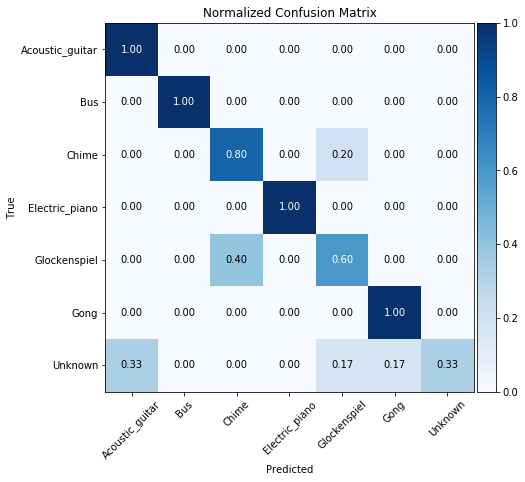

In [80]:
plot_cm(y3_2,y_hat_c3,figsize = (7,7), labels = labels, xrotation = 45)
plt.savefig('./cm_MC3-private.eps')

del(modelc3)

### Cluster 4

In [81]:
x4 = [x_test_private[f] for f in c4_indx]
y4 = [labels_test_private[f] for f in c4_indx]

In [82]:
c4_scores = [f[4] for i,f in enumerate(y_scores_MC) if i in c4_indx]

In [83]:
for i, score in zip(c4_indx,c4_scores):
    all_scores[i,label_to_num['Applause']] = score

### Cluster 5

In [84]:
x5 = [x_test_private[f] for f in c5_indx]
y5 = [labels_test_private[f] for f in c5_indx]

In [85]:
with open('./Clustering_V1_mappings/c5_mapping', 'rb') as fp:
    c5_label_mapping = pickle.load(fp)

c5_label_mapping_inv = dict([[v,k] for [k,v] in c5_label_mapping.items()])
c5_label_mapping_inv[len(c5_label_mapping_inv)] = 45
    
c5_labels = list(c5_label_mapping.keys())

In [86]:
c5_labels = list(c5_label_mapping.keys())

In [87]:
y5_2 = []

for f in y5:
    if f in c5_labels:
        y5_2.append(c5_label_mapping[f])
    else:
        y5_2.append(len(c5_labels))

In [88]:
sr = 16000
file_length = 64000
hop_length = 256
freq_res = 257
frames = int(np.ceil(file_length/hop_length))

input_shape = [freq_res,frames]

In [89]:
modelc5 = malley_cnn_120(input_shape,len(c5_labels)+1)
modelc5.load_weights('./outputs/best_weights/malley-C5-16k-PS-257-HL256[0].h5')
modelc5.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [90]:
y_scores_c5,edo= evaluate_complete_files(x5,y5_2,modelc5,[freq_res,frames])
y_hat_c5 = np.argmax(y_scores_c5,axis = 1)
np.mean(y_hat_c5==y5_2)

100%|██████████| 26/26 [00:00<00:00, 85.87it/s]


0.8846153846153846

In [91]:
x5_2 = create_quick_test_2d(x5,freq_res,frames)
modelc5.evaluate(x5_2,y5_2)

26/26 [==============================] - 1s 21ms/step


[0.20302344858646393, 0.9230769276618958]

### Save Scores in General Scores

In [92]:
#y_scores_c5 = modelc5.predict(x5_2)
#y_hat_c5 = np.argmax(y_scores_c5,axis = 1)

In [93]:
y_hat_c5_orig = [c5_label_mapping_inv[f] for f in y_hat_c5]

In [94]:
for i,this_scores in zip(c5_indx,y_scores_c5):
    for j,f in enumerate(this_scores):
        all_scores[i,c5_label_mapping_inv[j]] = f * (1-this_scores[-1])#y_scores_MC[i][5]

In [95]:
labels = [num_to_label[f] for f in c5_labels]
labels.append('Unknown')

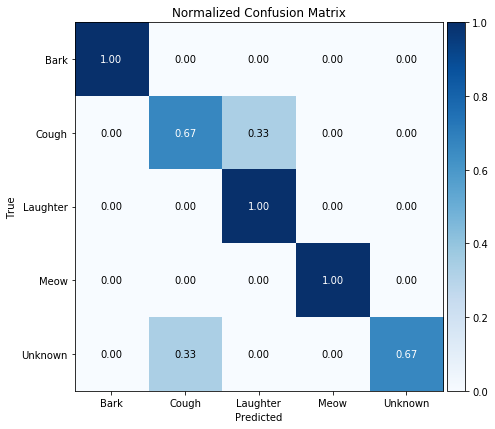

In [96]:
plot_cm(y5_2,y_hat_c5,figsize = (7,7), labels = labels)
plt.savefig('./cm_MC5-private.eps')

del(modelc5)

### Final Inference

In [97]:
from utilities import mapk

In [98]:
y_hat_final = np.argmax(all_scores[:,:41],axis = 1)

In [99]:
tha_best = []

for this_score in all_scores[:,:41]:
    tha_best.append(sorted(zip(this_score, np.arange(len(this_score))), reverse=True)[:3])

In [100]:
y_top_3 = [[a,b,c] for [(_,a),(_,b),(_,c)] in tha_best] 

In [101]:
mapk([[f] for f in labels_test_private],y_top_3,k=3)

0.8997785160575857

In [102]:
np.mean(y_hat_final==labels_test_private)

0.8637873754152824

In [126]:
num_to_label[41] = 'Unknown0'
num_to_label[42] = 'Unknown1'
num_to_label[43] = 'Unknown2'
num_to_label[44] = 'Unknown3'
num_to_label[45] = 'Unknown4'
num_to_label[46] = 'Unknown5'

In [166]:
with open('./preprocessed_test/WF-16k-64k','rb') as fp:
    waves = pickle.load(fp)

In [167]:
waves_public = [f for i,f in enumerate(waves) if test_data['usage'][i] == 'Public']

Text(0.5, 1.0, 'Real: Scissors 99')

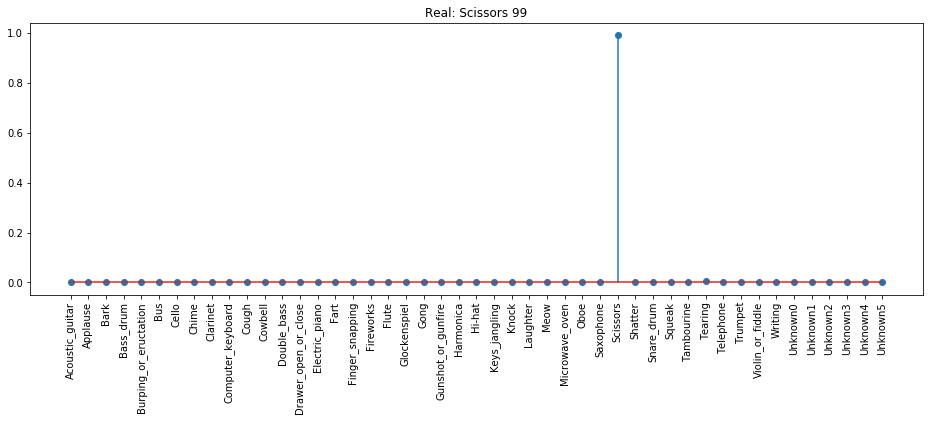

In [524]:
n=np.random.randint(0,301)
x = np.arange(47)

plt.figure(figsize = (16,5))
plt.stem(all_scores[n])
ticks = plt.xticks(ticks = x,labels= [num_to_label[f] for f in x], rotation = 90)
plt.title('Real: {} {}'.format(num_to_label[labels_test_public[n]],n))

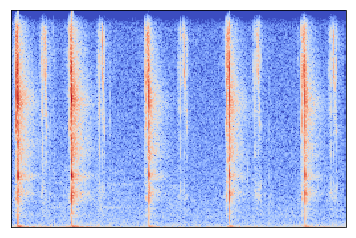

In [525]:
librosa.display.specshow(x_test_32k_public[n])

In [526]:
Audio(waves_public[n],rate = 16000)

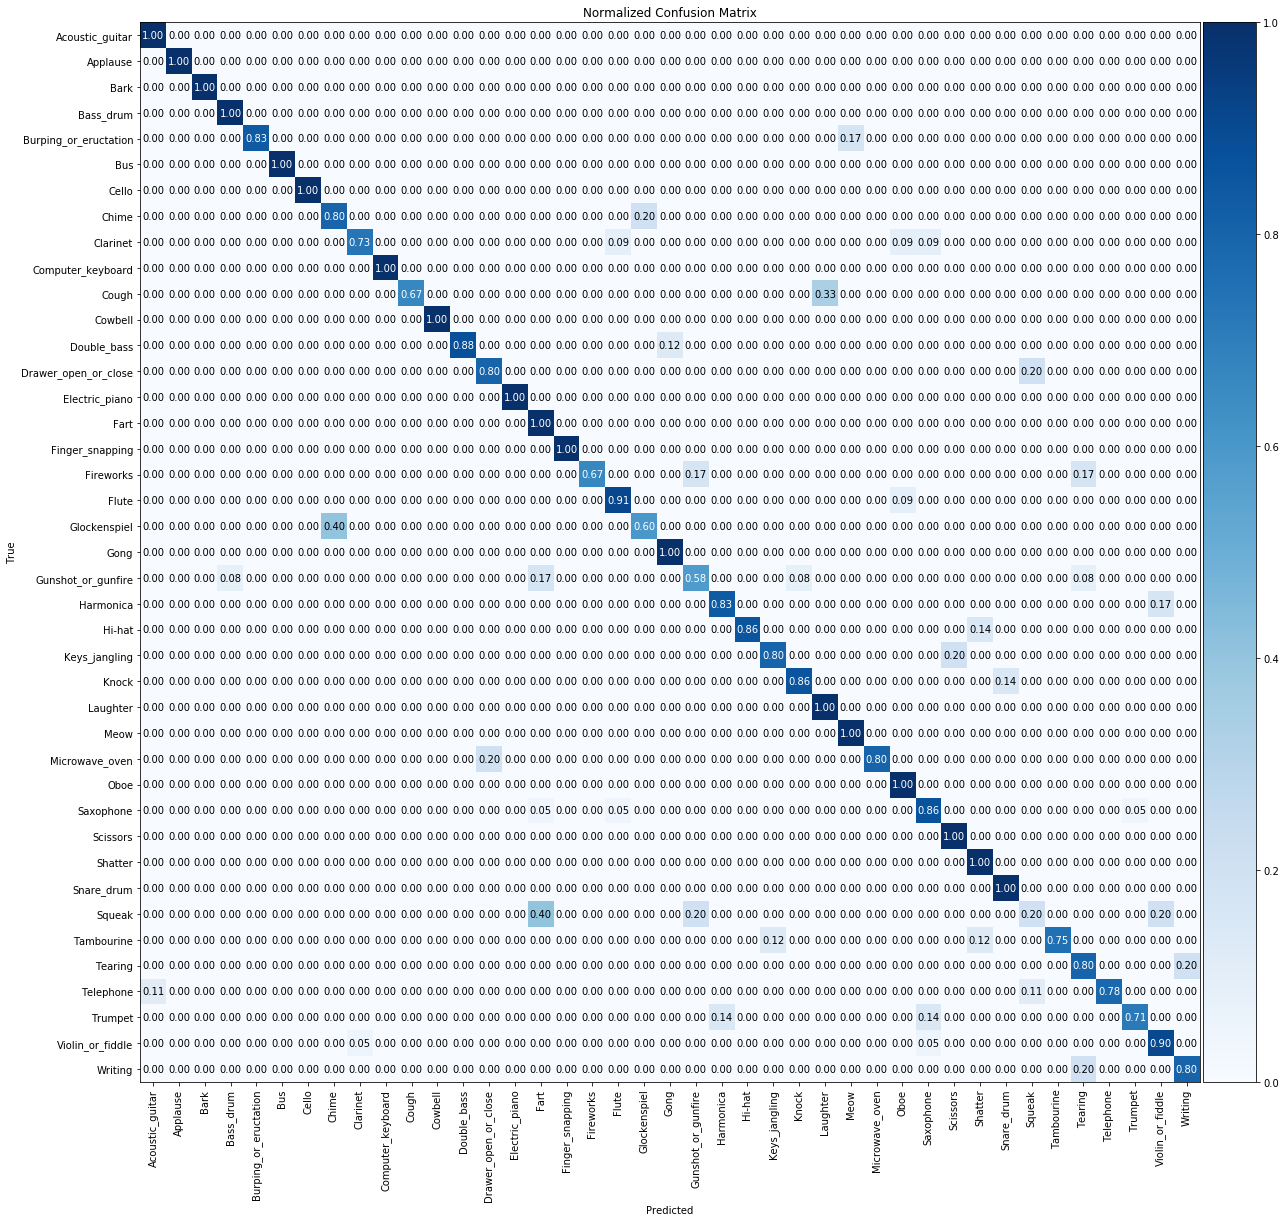

In [134]:
labels = list(num_to_label.values())
plot_cm(labels_test_public,y_hat_final,figsize = (20,20), labels = labels, xrotation=90)
plt.savefig('./cm_all_41classes.eps')